# Incremental Learning

StyleBank在Perceptual Loss For Real Time Transfer的结构基础上更进了一步，接入VGG之前，不是一个全CNN网络了，而是一个auto encoder结构，在auto encoder中间的latent space，使用style bank来更改其风格。这样我们就能做到auto encoder是预训练的，而style bank是一个“可拔插”的结构。可以在预训练好的auto encoder基础上，单独训练某个特定风格的style bank。  

这里我们直接使用预训练好的auto encoder，以及vgg-16，去训练style bank


In [1]:
import time
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import image_utils

from args import TrainArgs
import utils
from networks import LossNetwork, StyleBankNet


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# 当前目录
#current_directory = os.path.dirname(os.path.abspath(__file__))
current_directory = os.getcwd()

default_resource_dir = os.path.join(current_directory, "..", "Images")
content_images_dir = os.path.join(default_resource_dir, 'original')
style_images_dir = os.path.join(default_resource_dir, 'cartoon')
model_dir = os.path.join(current_directory, "weights")


# 这里修改训练参数
args = TrainArgs()
args.continue_training = False 
args.CONTENT_IMG_DIR = content_images_dir
args.STYLE_IMG_DIR = style_images_dir
args.SetModelWeightDir(model_dir)
args.SetNewBankWeightDir("bank_cartoon")
# 默认1000
args.SetK(100)

device = args.device

d:\Program Files\Anaconda3\envs\pytorchgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device:cuda:0
device:cuda:0


In [2]:
"""
Load Dataset
"""
content_dataset = image_utils.ImageFolder(root_path=args.CONTENT_IMG_DIR, transform=utils.content_img_transform)
content_dataloader = torch.utils.data.DataLoader(content_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4)

style_dataset = image_utils.ImageFolder(root_path=args.STYLE_IMG_DIR, transform=utils.style_img_transform)
# 在这里把style image都提出来，存成(batch_size, 3, w, h)的格式
style_images = []
for img in style_dataset:
    cur_styleimage = img.view(1, *img.shape)
    style_images.append(cur_styleimage)
style_dataset = torch.cat(style_images, dim=0)

style_dataset = style_dataset.to(device)


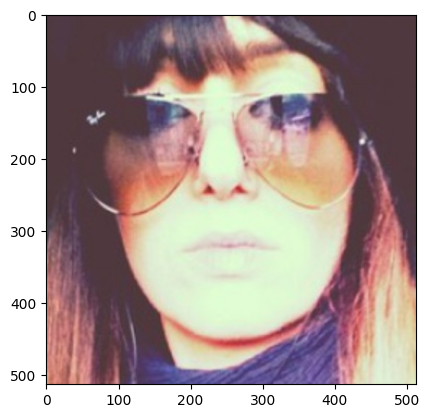

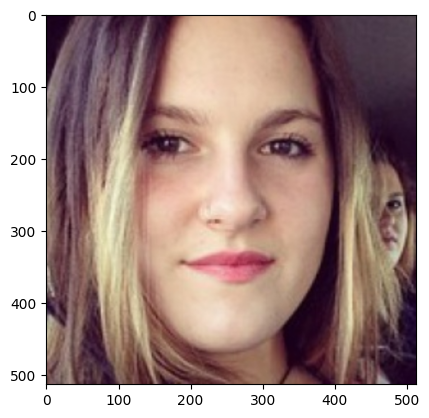

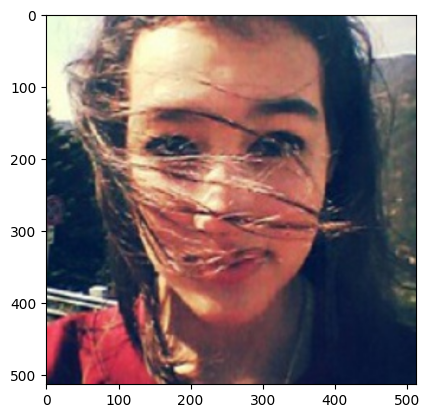

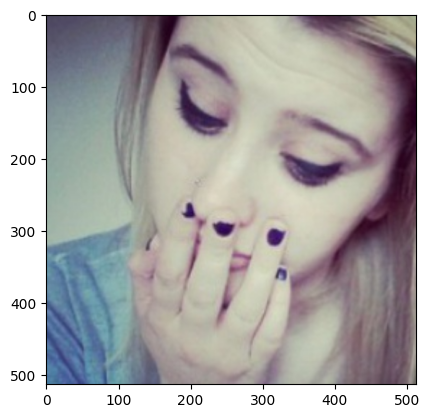

In [3]:
"""
Display content images
"""
for imgs in content_dataloader:
    for i in range(args.batch_size):
        utils.showimg(imgs[i])
    break

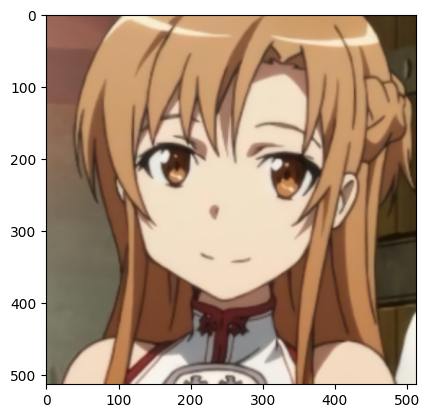

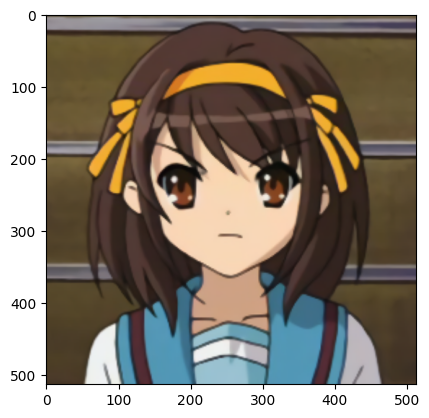

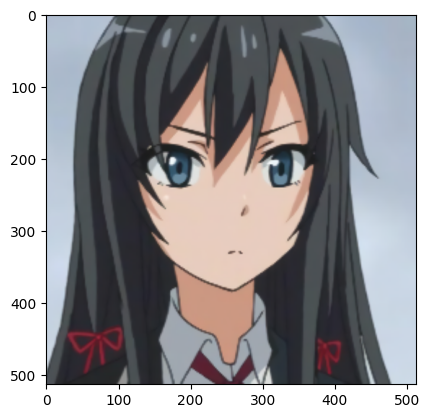

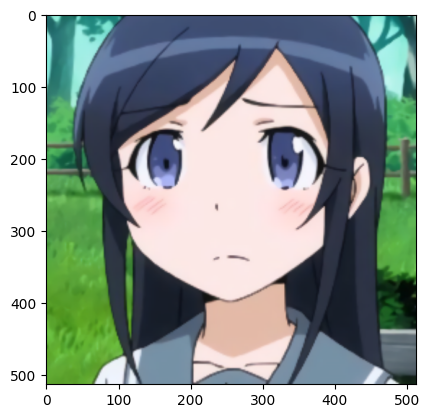

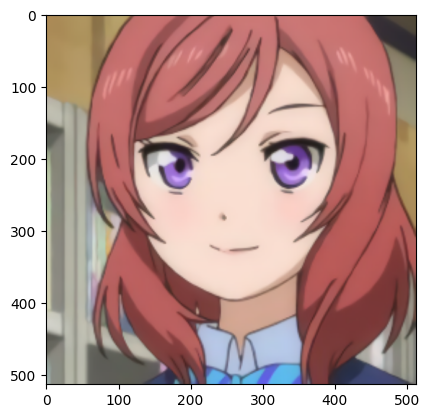

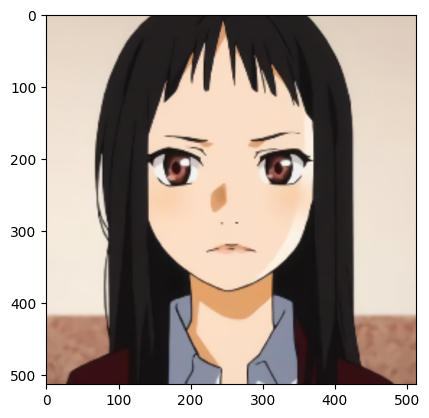

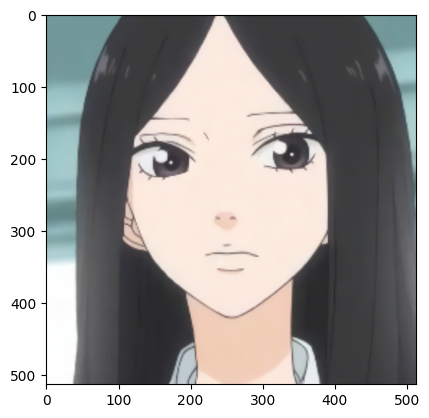

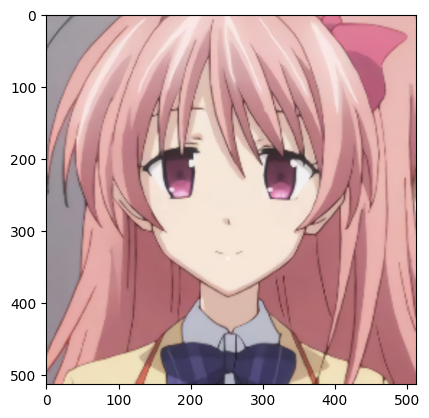

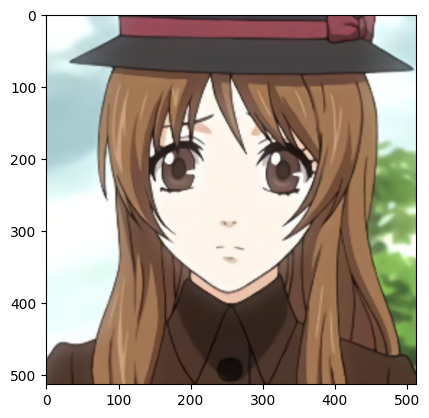

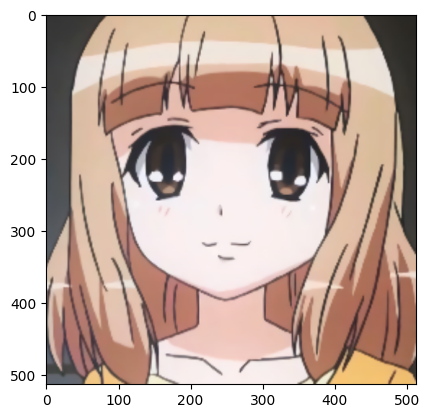

In [4]:
"""
Display style images
"""
for img in style_dataset:
    utils.showimg(img)

In [5]:
"""
Define Model and Loss Network (vgg16)
"""
# 加载model
model = StyleBankNet(len(style_dataset)).to(device)
# 读取encoder权重
if os.path.exists(args.ENCODER_WEIGHT_PATH):
    model.encoder_net.load_state_dict(torch.load(args.ENCODER_WEIGHT_PATH))
else:
    raise Exception('cannot find encoder weights')

# 读取decoder权重
if os.path.exists(args.DECODER_WEIGHT_PATH):
    model.decoder_net.load_state_dict(torch.load(args.DECODER_WEIGHT_PATH))
else:
    raise Exception('cannot find encoder weights')

if not os.path.exists(args.NEW_BANK_WEIGHT_DIR):
    os.mkdir(args.NEW_BANK_WEIGHT_DIR)

# 只有style bank是train模式，其他部分完全固定
model.encoder_net.eval()
model.decoder_net.eval()
model.style_bank.train()
# only update the bank
optimizer = optim.Adam(model.style_bank.parameters(), lr=args.lr)
loss_network = LossNetwork().to(device)

e:\workspace\577-project\StyleBank\networks.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
e:\workspace\577-project\StyleBank\networks.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


下面开始训练新的style bank

In [6]:
"""
Training
"""

# [0, 1, 2, ..., N]，style的数量
style_id = list(range(len(style_dataset)))
style_id_idx = 0
style_id_seg = []
# 为batch中每张图分配style id
for i in range(0, len(style_dataset), args.batch_size):
    style_id_seg.append(style_id[i:i+args.batch_size])
    
s_sum = 0 # sum of style loss
c_sum = 0 # sum of content loss
l_sum = 0 # sum of style+content loss
tv_sum = 0 # sum of tv loss

global_step = 0
LOG_ITER = int(args.LOG_ITER)

while global_step <= args.MAX_ITERATION:
    for i, data in enumerate(content_dataloader):
        global_step += 1
        data = data.to(device)
        batch_size = data.shape[0]
        
        style_id_idx += 1
        # 得到batch中每张图对应用哪个style id，每次都换一组style
        sid = utils.get_sid_batch(style_id_seg[style_id_idx % len(style_id_seg)], batch_size)

        optimizer.zero_grad()
        # 进入auto encoder
        output_image = model(data, sid)
        # 进入vgg-16，算出style loss和content loss
        content_score, style_score = loss_network(output_image, data, style_dataset[sid])
        content_loss = args.CONTENT_WEIGHT * content_score
        style_loss = args.STYLE_WEIGHT * style_score
        # 计算tv loss，后一个像素减去前一个像素求绝对值，得到亮度差异，求和就是tv loss
        diff_i = torch.sum(torch.abs(output_image[:, :, :, 1:] - output_image[:, :, :, :-1]))
        diff_j = torch.sum(torch.abs(output_image[:, :, 1:, :] - output_image[:, :, :-1, :]))
        tv_loss = args.REG_WEIGHT*(diff_i + diff_j)

        total_loss = content_loss + style_loss + tv_loss
        total_loss.backward()
        optimizer.step()

        l_sum += total_loss.item()
        s_sum += style_loss.item()
        c_sum += content_loss.item()
        tv_sum += tv_loss.item()
            
        if global_step % 100 == 0:
            print('.', end='')
            
        if global_step % LOG_ITER == 0:
            print("gs: {} {} {:.6f} {:.6f} {:.6f} {:.6f}".format(int(global_step / args.K), time.strftime("%H:%M:%S"), l_sum / LOG_ITER, c_sum / LOG_ITER, s_sum / LOG_ITER, tv_sum / LOG_ITER))
            s_sum = 0
            c_sum = 0
            l_sum = 0
            tv_sum = 0

            # save the bank
            for i in range(len(style_dataset)):
                torch.save(model.style_bank[i].state_dict(), args.NEW_BANK_WEIGHT_PATH.format(i))
            
        if global_step % args.ADJUST_LR_ITER == 0:
            lr_step = global_step / args.ADJUST_LR_ITER
            new_lr = utils.adjust_learning_rate(optimizer, lr_step, args)
            
            print("learning rate decay:", new_lr)

.gs: 1 20:37:12 421.161759 54.690377 365.409348 1.062036
.gs: 2 20:39:25 194.786523 55.135331 138.621296 1.029896
.gs: 3 20:41:39 154.410527 54.109178 99.299065 1.002285
.gs: 4 20:43:58 138.863916 53.518754 84.344288 1.000873
.gs: 5 20:46:17 127.911858 52.918779 73.995647 0.997431
.gs: 6 20:48:32 124.106891 52.386003 70.733972 0.986915
.gs: 7 20:50:47 116.335794 51.825552 63.524958 0.985283
.gs: 8 20:53:00 115.343766 51.681207 62.672932 0.989626
.gs: 9 20:55:12 113.534773 51.457999 61.099195 0.977579
.gs: 10 20:57:28 108.502057 51.087273 56.436286 0.978498
learning rate decay: 0.0008
.gs: 11 21:00:12 103.471740 50.618526 51.877135 0.976079
.gs: 12 21:02:37 101.675690 50.220617 50.487834 0.967239
.gs: 13 21:05:41 99.561478 49.703122 48.889559 0.968797
.gs: 14 21:07:55 99.129319 49.890862 48.266361 0.972096
.gs: 15 21:10:10 98.793631 49.574793 48.252110 0.966728
.gs: 16 21:12:26 97.094352 49.389612 46.735388 0.969352
.gs: 17 21:14:39 95.881678 49.335768 45.575222 0.970688
.gs: 18 21:16:5

RuntimeError: DataLoader worker (pid(s) 468184, 468168, 468212, 467312) exited unexpectedly

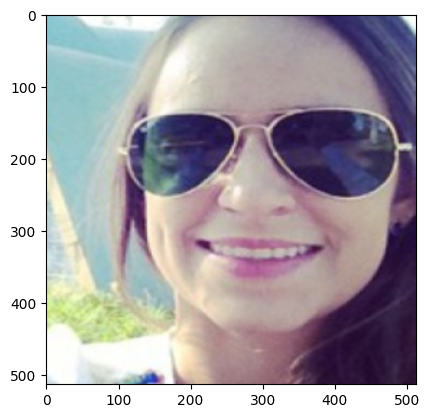

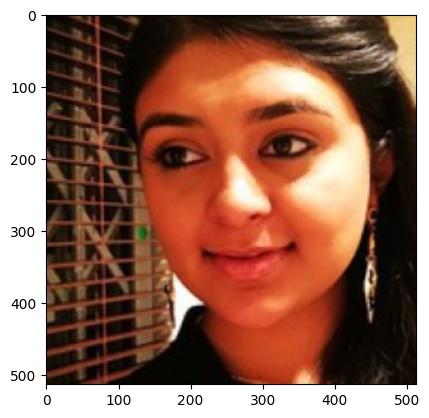

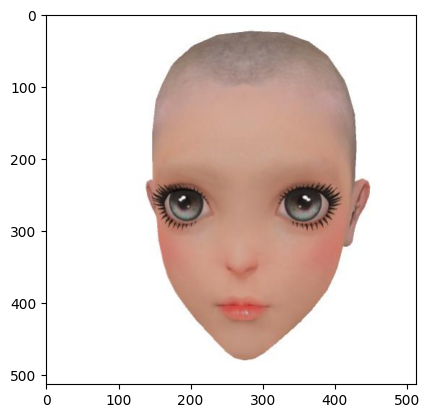

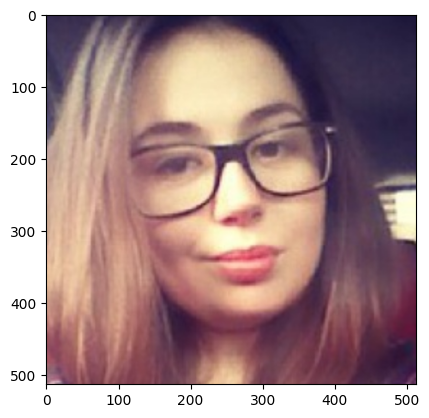

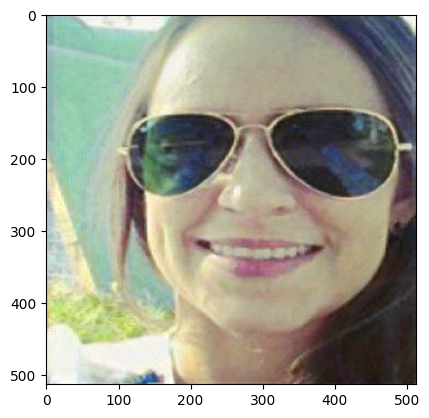

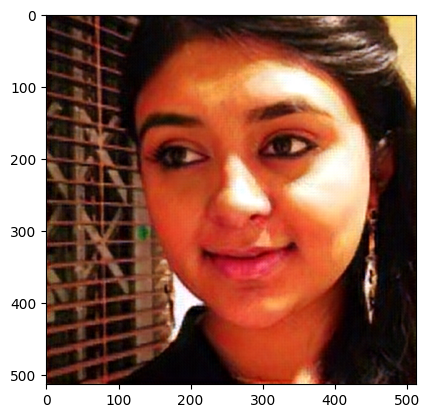

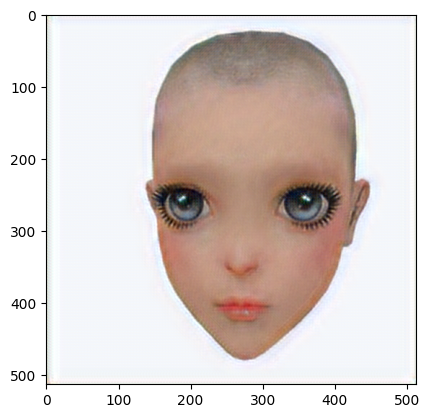

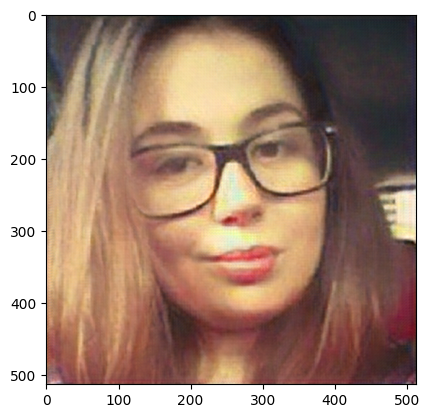

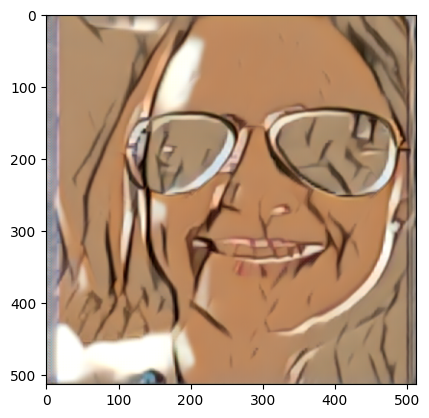

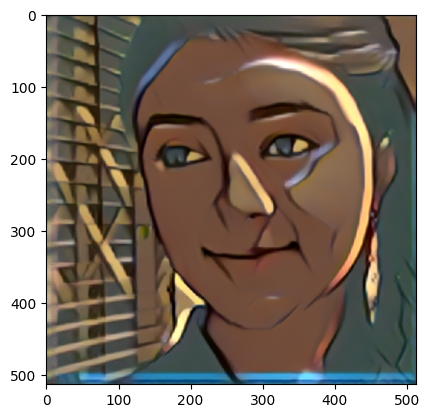

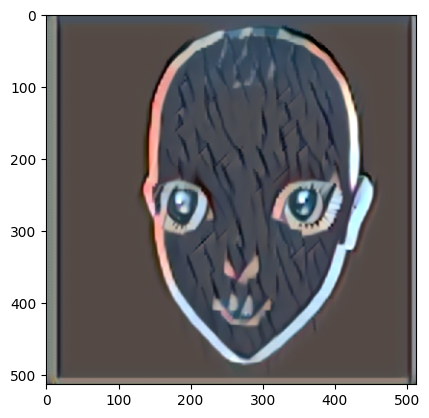

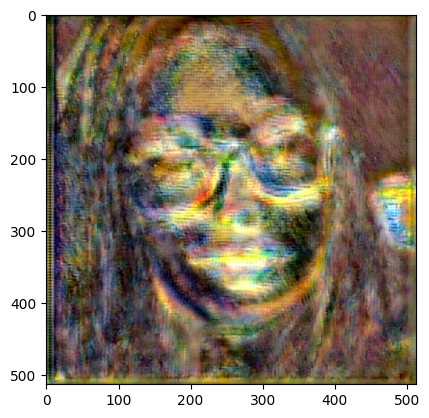

In [7]:
"""
Testing
"""
for i, data in enumerate(content_dataloader, 0):
    data = data.to(device)
    batch_size = data.shape[0]
#     data = data[0].repeat(batch_size, 1, 1, 1)
    for j in range(batch_size):
        utils.showimg(data[j].cpu())
    
    output_image = model(data)
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    output_image = model(data, utils.get_sid_batch(style_id_seg[0], batch_size))
    for j in range(batch_size):
        utils.showimg(output_image[j].cpu().detach())
    break